In [93]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [94]:
tcikerSymbol = 'QCOM'
df = yf.Ticker(tcikerSymbol)

In [95]:
df = df.history(period='1d', start='2014-01-01', end='2024-01-01')

In [96]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-02 00:00:00-05:00,54.956062,55.075512,54.694758,54.739552,10110200,0.0,0.0
2014-01-03 00:00:00-05:00,54.747009,54.858998,54.082550,54.418510,7970400,0.0,0.0
2014-01-06 00:00:00-05:00,54.560386,54.649972,54.164697,54.276680,7696200,0.0,0.0
2014-01-07 00:00:00-05:00,54.351343,54.732097,54.202023,54.679836,5902700,0.0,0.0
2014-01-08 00:00:00-05:00,54.612627,55.008316,54.261732,55.008316,8976900,0.0,0.0


In [97]:
def plot_stocks():
  plt.figure(figsize=(10,6))
  plt.plot(df.index, df['Close'], label='Close price')
  plt.title('Historical price for Qualcomm')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.legend()
  plt.show()


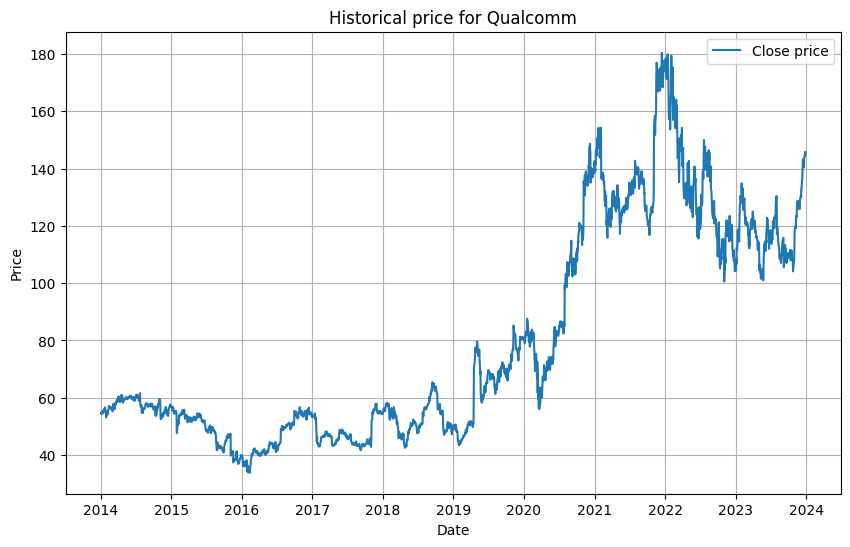

In [98]:
plot_stocks()

In [99]:
data = df['Close'].values
split = int(len(data) * 0.8)
train_data = data[:split]
val_data = data[split:]
time = df.index.values
train_time = time[:split]
val_time = time[split:]

In [100]:
def window_dataset(series, window_size, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [101]:
window_size= 30
batch_size = 32
buffer_size= 1000

In [102]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


In [103]:
init_weights = model.get_weights()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

train_set = window_dataset(train_data, window_size, batch_size, buffer_size)
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 6s 38ms/step - loss: 55.6774 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 3s 54ms/step - loss: 45.5933 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 3s 41ms/step - loss: 36.2414 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 4s 68ms/step - loss: 26.4284 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 4s 62ms/step - loss: 16.1681 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 2s 36ms/step - loss: 12.5726 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 2s 37ms/step - loss: 12.2321 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 2s 36ms/step - loss: 11.8063 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 3s 51ms/step - loss: 11.3541 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 3s 37ms/step - loss: 10.8695 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

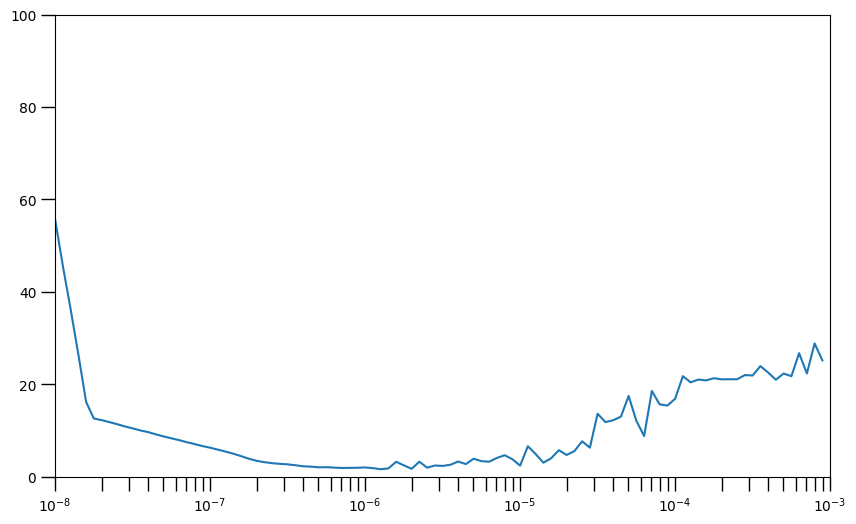

In [104]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10,6))
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

In [106]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)
learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_tuned = model.fit(train_set, epochs=100)


Epoch 1/100
62/62 [==============================] - 16s 38ms/step - loss: 16.9966 - mae: 17.4850
Epoch 2/100
62/62 [==============================] - 2s 37ms/step - loss: 5.6980 - mae: 6.1506
Epoch 3/100
62/62 [==============================] - 3s 49ms/step - loss: 3.4475 - mae: 3.8923
Epoch 4/100
62/62 [==============================] - 2s 36ms/step - loss: 2.5389 - mae: 2.9825
Epoch 5/100
62/62 [==============================] - 2s 36ms/step - loss: 2.1341 - mae: 2.5602
Epoch 6/100
62/62 [==============================] - 2s 36ms/step - loss: 2.0533 - mae: 2.4804
Epoch 7/100
62/62 [==============================] - 3s 47ms/step - loss: 2.0032 - mae: 2.4274
Epoch 8/100
62/62 [==============================] - 3s 40ms/step - loss: 1.9149 - mae: 2.3379
Epoch 9/100
62/62 [==============================] - 2s 36ms/step - loss: 1.8591 - mae: 2.2919
Epoch 10/100
62/62 [==============================] - 2s 36ms/step - loss: 1.7248 - mae: 2.1403
Epoch 11/100
62/62 [==========================

In [107]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [108]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

16/16 [==============================] - 1s 15ms/step


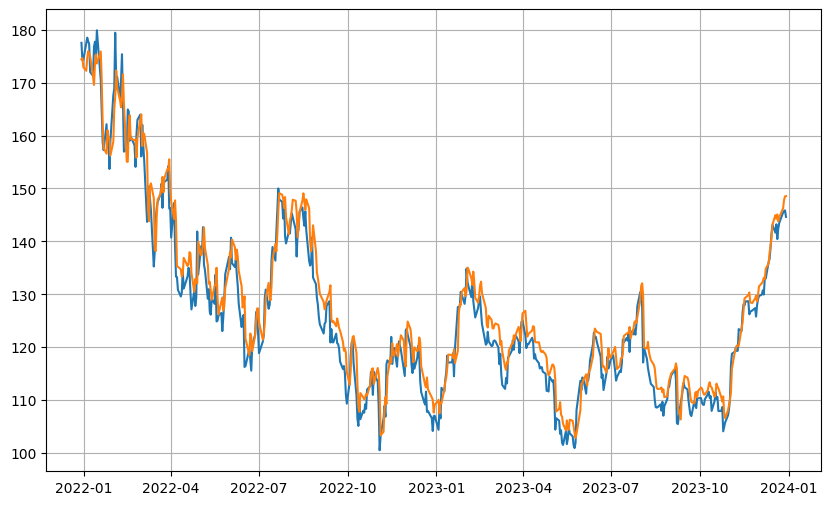

mae 3.1387722492218018


In [109]:
forecast_series = data[split-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(val_time, (val_data, results))
print(f"mae {tf.keras.metrics.mean_absolute_error(val_data, results)}")

In [ ]:
train = window_dataset(data, window_size, batch_size, buffer_size)
learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
model.set_weights(init_weights)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
history = model.fit(train, epochs=100)

In [ ]:
predictions=[]
copy_data = data.tolist().copy()
for i in range(30):
    training = np.array(copy_data[-30:])
    print(training)
    windowed_prediciton_data = model_forecast(model, training, window_size, batch_size)
    result = windowed_prediciton_data.squeeze()
    copy_data.append(result)
    print(len(copy_data))
    predictions.append(result)

